In [200]:
import pandas as pd
import quandl
from scipy import stats
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

quandl.ApiConfig.api_key = 'm8FYMyoCaJSbTrBASNHh'

In [175]:
data = pd.read_csv('data_for_pull.csv')

In [176]:
data['Quandl Key'].astype('str')

0         SGE/USABCONF
1           SGE/USAUNR
2          SGE/USAUNRY
3             FRED/GDP
4          SGE/USACNCN
5           SGE/USAEHS
6     FRED/LNS12032199
7     FRED/WPUSI019011
8          FRED/PERMIT
9           FRED/HOUST
10            FRED/TCU
11         SGE/USAPSAV
12        SGE/USAEXVOL
13        SGE/USAIMVOL
14          SGE/USABOT
15         FRED/T10Y3M
Name: Quandl Key, dtype: object

In [177]:
dataset = quandl.get([val for val in data['Quandl Key']])

In [178]:
dataset

,SGE/USABCONF - Value,SGE/USAUNR - Value,SGE/USAUNRY - Value,FRED/GDP - Value,SGE/USACNCN - Value,SGE/USAEHS - Value,FRED/LNS12032199 - Value,FRED/WPUSI019011 - Value,FRED/PERMIT - Value,FRED/HOUST - Value,FRED/TCU - Value,SGE/USAPSAV - Value,SGE/USAEXVOL - Value,SGE/USAIMVOL - Value,SGE/USABOT - Value,FRED/T10Y3M - Value
Date,,,,,,,,,,,,,,,,
1947-01-01,NaN,NaN,NaN,243.164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-01,NaN,NaN,NaN,245.968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-07-01,NaN,NaN,NaN,249.585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-10-01,NaN,NaN,NaN,259.745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-01-01,NaN,NaN,NaN,265.742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-01-31,51.7,3.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-02-29,50.2,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-03-31,43.3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-04-01,NaN,NaN,NaN,272.567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
type(dataset.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [180]:
dataset.index = dataset.index.strftime('%Y-%m')

In [181]:
dataset = dataset.groupby(dataset.index, as_index=True).agg(sum)

In [182]:
dataset

,SGE/USABCONF - Value,SGE/USAUNR - Value,SGE/USAUNRY - Value,FRED/GDP - Value,SGE/USACNCN - Value,SGE/USAEHS - Value,FRED/LNS12032199 - Value,FRED/WPUSI019011 - Value,FRED/PERMIT - Value,FRED/HOUST - Value,FRED/TCU - Value,SGE/USAPSAV - Value,SGE/USAEXVOL - Value,SGE/USAIMVOL - Value,SGE/USABOT - Value,FRED/T10Y3M - Value
1947-01,0.0,0.0,0.0,243.164,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00
1947-04,0.0,0.0,0.0,245.968,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00
1947-07,0.0,0.0,0.0,249.585,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00
1947-10,0.0,0.0,0.0,259.745,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00
1948-01,51.7,3.4,0.0,265.742,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00
1948-02,50.2,3.8,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00
1948-03,43.3,4.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00
1948-04,45.4,3.9,0.0,272.567,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00
1948-05,49.5,3.5,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00
1948-06,53.0,3.6,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00


In [183]:

i = 0

for val in dataset['FRED/GDP - Value']:
    if val == 0:
        dataset['FRED/GDP - Value'].iloc[i] = dataset['FRED/GDP - Value'].iloc[i-1]
        #print(i)
    
    i += 1

In [184]:
dataset['Recession'] = ((dataset['FRED/GDP - Value'] - dataset['FRED/GDP - Value'].shift(3)) < 0).astype(int)

In [185]:
dataset

,SGE/USABCONF - Value,SGE/USAUNR - Value,SGE/USAUNRY - Value,FRED/GDP - Value,SGE/USACNCN - Value,SGE/USAEHS - Value,FRED/LNS12032199 - Value,FRED/WPUSI019011 - Value,FRED/PERMIT - Value,FRED/HOUST - Value,FRED/TCU - Value,SGE/USAPSAV - Value,SGE/USAEXVOL - Value,SGE/USAIMVOL - Value,SGE/USABOT - Value,FRED/T10Y3M - Value,Recession
1947-01,0.0,0.0,0.0,243.164,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00,0
1947-04,0.0,0.0,0.0,245.968,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00,0
1947-07,0.0,0.0,0.0,249.585,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00,0
1947-10,0.0,0.0,0.0,259.745,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00,0
1948-01,51.7,3.4,0.0,265.742,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00,0
1948-02,50.2,3.8,0.0,265.742,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00,0
1948-03,43.3,4.0,0.0,265.742,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00,0
1948-04,45.4,3.9,0.0,272.567,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00,0
1948-05,49.5,3.5,0.0,272.567,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00,0
1948-06,53.0,3.6,0.0,272.567,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.00,0


In [186]:
y = dataset['Recession']

In [187]:
dataset = dataset.drop(columns = ['FRED/GDP - Value','Recession'])

In [189]:
X = dataset

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=45)

In [191]:
model = LogisticRegression()
model.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [193]:
probs = model.predict_proba(X_test)

In [197]:
log_loss(y_test, probs)

0.12246928089034341

In [198]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


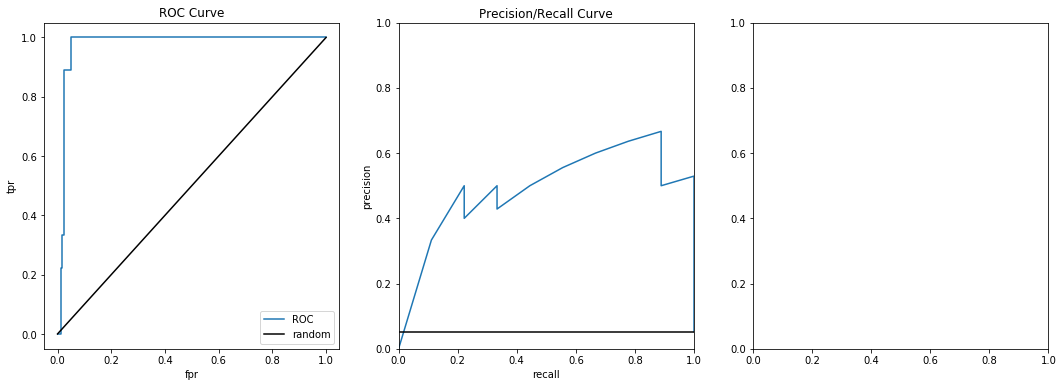

In [201]:
fig, (ax0, ax1, ax3) = plt.subplots(1,3, figsize=(18,6))
df = calculate_threshold_values(model.predict_proba(X_test)[:,1], y_test)
plot_roc(ax0, df)
plot_precision_recall(ax1, df)

In [202]:
y_test, probs

(1974-02    0
 1974-06    0
 1992-01    0
 1989-08    0
 2005-03    0
 1955-09    0
 1961-05    0
 1978-11    0
 1964-09    0
 1968-06    0
 2015-11    0
 1999-03    0
 1947-10    0
 1992-09    0
 2007-11    0
 1958-10    0
 1989-02    0
 1995-01    0
 2006-10    0
 1986-08    0
 2005-07    0
 2001-10    0
 1961-11    0
 2016-06    0
 1950-06    0
 1958-01    1
 1952-12    0
 2010-10    0
 1995-12    0
 2011-11    0
           ..
 1973-02    0
 2000-03    0
 2009-09    0
 2003-06    0
 2004-10    0
 2004-03    0
 1988-04    0
 1968-07    0
 1963-08    0
 1960-07    0
 1976-08    0
 2008-12    1
 1959-12    0
 1948-08    0
 1985-12    0
 2010-12    0
 1962-09    0
 1961-03    0
 1999-11    0
 1993-07    0
 1966-05    0
 1971-07    0
 1971-02    0
 1957-09    0
 1999-07    0
 1951-05    0
 1988-02    0
 1980-12    0
 2008-11    1
 2003-01    0
 Name: Recession, Length: 172, dtype: int64, array([[0.99289012, 0.00710988],
        [0.9927812 , 0.0072188 ],
        [0.97050971, 0.02949029],
